In [343]:
import requests
import numpy as np
import tensorflow as tf
from pathlib import Path
import pickle
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical

np.random.seed(0)

In [344]:
def download_datasets(url, dataset_name):
    path_to_zip = tf.keras.utils.get_file(
        fname=f"{dataset_name}.tar.gz",
        origin=url,
        extract=True)

    path_to_zip = Path(path_to_zip)
    path = path_to_zip.parent / dataset_name
    return path_to_zip, path

In [345]:
# Copy from https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [346]:
def extract_cifar10_batches(batch_dic):
    batch_labels = batch_dic.get(b'labels')
    batch_images = batch_dic.get(b'data')
    batch_filenames = batch_dic.get(b'filenames')
    return batch_labels, batch_images, batch_filenames

In [347]:
def extract_cifar100_batches(batch_dic):
    fine_labels = batch_dic.get(b'fine_labels')
    coarse_labels = batch_dic.get(b'coarse_labels')
    images = batch_dic.get(b'data')
    filenames = batch_dic.get(b'filenames')
    return fine_labels, coarse_labels, images, filenames

In [348]:
def get_classes_dic(key, class_names, dic):
    labels = dic.get(key)
    labels = list(map(lambda x: x.decode('utf-8'), labels))
    labels_nr = [index for index, value in enumerate(labels) if value in class_names]
    labels =  [value for _, value in enumerate(labels) if value in class_names]
    return labels, labels_nr

In [349]:
def filter_class(classes, labels, images, filenames):
    filtered_labels = [label for label in labels if label in classes]
    filtered_images = []
    filtered_filenames = []

    for i in range(len(labels)):
        if labels[i] in classes:
            filtered_images.append(images[i])
            filtered_filenames.append(filenames[i])

    return np.array(filtered_labels), np.array(filtered_images), np.array(filtered_filenames)

In [350]:
def group_fine_with_superclass(new_index, f_labels, c_labels, selected_fine_classes, new_val):
    selected_fine_classes.append(new_index)

    for i in range(len(f_labels)):
        f_labels[i] = new_index if c_labels[i] == new_val else f_labels[i]

    return f_labels

In [351]:
def get_data(batchnames, batch_size, path,needed_classes, with_superclass = False, needed_superclass = []):
    data_labels = []
    data_images = []
    data_filenames = []
    data_superclass = []

    for name in batchnames:
        batch_dic = unpickle(str(path / name))

        if with_superclass:
            labels, coarse_labels, images, filenames = extract_cifar100_batches(batch_dic)
            data_superclass.extend(coarse_labels)
        else:
            labels, images, filenames = extract_cifar10_batches(batch_dic)

        data_labels.extend(labels)
        data_images.extend(images)
        data_filenames.extend(filenames)
        assert((images.shape[1] == 3072)), 'images are not in 3072 bytes'


    assert((len(data_images) == batch_size)), f'images contains not all {batch_size} images'
    assert((len(data_filenames) == batch_size)), f'filenames contains not all {batch_size} filenames'

    if with_superclass:
        assert((len(data_labels) == batch_size)), f'fine labels contains not all {batch_size} labels'
        assert((len(coarse_labels) == batch_size)), f'coarse labels contains not all {batch_size} labels'

        # Only one needed superclass
        for i in range(len(needed_superclass)):
            data_labels = group_fine_with_superclass(((i+1) * -1), data_labels, coarse_labels, needed_classes, needed_superclass[i])
        data_labels, data_images, data_filenames = filter_class(needed_classes, data_labels, data_images, data_filenames)

    else:
        assert((len(data_labels) == batch_size)), f'labels contains not all {batch_size} labels'
        data_labels, data_images, data_filenames = filter_class(needed_classes, data_labels, data_images, data_filenames)

    return data_labels, data_images, data_filenames


In [352]:
def remap_labels(labels, start_step = 0):
    label_mapping = {label: index + start_step for index, label in enumerate(sorted(set(labels)))}
    labels = [label_mapping[label] for label in labels]
    return labels

In [353]:
def merge_datasets(labels1, labels2, images1, images2):
    print(len(labels1), len(labels2))
    x_data = np.concatenate([images1, images2], axis=0)
    y_data = np.concatenate([labels1, labels2], axis=0)
    print(len(x_data), len(y_data))
    print(set(y_data), len(set(y_data)))
    return x_data, y_data

In [354]:
cifar10_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
cifar100_url = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
zip, cifar10_path = download_datasets(cifar10_url, 'cifar-10-batches-py')
zip, cifar100_path = download_datasets(cifar100_url, 'cifar-100-python')

In [355]:
# class_labels: 1, 2, 3, 4, 5, 7, 9
dic_file = 'batches.meta'
needed_cifar10_classes = ['automobile', 'bird',  'cat', 'deer', 'dog', 'horse', 'truck']
cifar10_dic = unpickle(str(cifar10_path / dic_file))
selected_cifar10_classnames, selected_cifar10_classes = get_classes_dic(b'label_names', needed_cifar10_classes, cifar10_dic)
print(selected_cifar10_classnames)
print(selected_cifar10_classes)

['automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'truck']
[1, 2, 3, 4, 5, 7, 9]


In [356]:
# Cifar 100
needed_cifar100_fine_classes = ['cattle', 'fox', 'baby', 'boy', 'girl', 'man', 'woman', 'rabbit', 'squirrel', 'bicycle', 'bus', 'motorcycle', 'pickup_truck',
                                'train', 'lawn_mower', 'tractor']
needed_cifar100_superclasses = ['trees']

cifar100_dic = unpickle(str(cifar100_path / 'meta'))
keys_list = list(cifar100_dic.keys())

selected_cifar100_fine_classnames, selected_cifar100_fine_classes = get_classes_dic(keys_list[0], needed_cifar100_fine_classes, cifar100_dic)
print(selected_cifar100_fine_classnames, selected_cifar100_fine_classes)

selected_cifar100_superclassnames, selected_cifar100_superclasses = get_classes_dic(keys_list[1], needed_cifar100_superclasses, cifar100_dic)
print(selected_cifar100_superclassnames, selected_cifar100_superclasses)

['baby', 'bicycle', 'boy', 'bus', 'cattle', 'fox', 'girl', 'lawn_mower', 'man', 'motorcycle', 'pickup_truck', 'rabbit', 'squirrel', 'tractor', 'train', 'woman'] [2, 8, 11, 13, 19, 34, 35, 41, 46, 48, 58, 65, 80, 89, 90, 98]
['trees'] [17]


In [357]:
#Cifar10 Train data
batchnames = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
cifar10_labels, cifar10_images, cifar10_filenames = get_data(batchnames, 50000, cifar10_path, selected_cifar10_classes)

# Cifar10 Test data
cifar10_test_labels, cifar10_test_images, cifar10_test_filenames = get_data(['test_batch'], 10000, cifar10_path, selected_cifar10_classes)

# Cifar100 Train data
cifar100_labels, cifar100_images, cifar100_filenames  = get_data(['train'], 50000, cifar100_path, selected_cifar100_fine_classes, True, selected_cifar100_superclasses)

# Cifar100 Test data
cifar100_test_labels, cifar100_test_images, cifar100_test_filenames = get_data(['test'], 10000, cifar100_path, selected_cifar100_fine_classes, True, selected_cifar100_superclasses)

In [358]:
# Remap
cifar10_labels = remap_labels(cifar10_labels)
cifar100_labels = remap_labels(cifar100_labels, len(set(cifar10_labels)))

cifar10_test_labels = remap_labels(cifar10_test_labels)
cifar100_test_labels = remap_labels(cifar100_test_labels, len(set(cifar10_test_labels)))

dic_classnames = selected_cifar10_classnames + selected_cifar100_superclassnames + selected_cifar100_fine_classnames
dic_labels = [i for i in range(len(selected_cifar10_classnames) + len(selected_cifar100_superclassnames) + len(selected_cifar100_fine_classnames))]
print(dic_labels)
print(dic_classnames)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
['automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'truck', 'trees', 'baby', 'bicycle', 'boy', 'bus', 'cattle', 'fox', 'girl', 'lawn_mower', 'man', 'motorcycle', 'pickup_truck', 'rabbit', 'squirrel', 'tractor', 'train', 'woman']


In [359]:
x_train, y_train = merge_datasets(cifar10_labels, cifar100_labels, cifar10_images, cifar100_images)
x_test, y_test = merge_datasets(cifar10_test_labels, cifar100_test_labels, cifar10_test_images, cifar100_test_images)

35000 10500


45500 45500
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} 24
7000 2100
9100 9100
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} 24


In [360]:
# CHATGPT
def load_image(image):
    image_data_reshaped = np.reshape(image, (32, 32, 3), order='F')
    image = Image.fromarray(image_data_reshaped.astype('uint8'))
    return np.array(image)

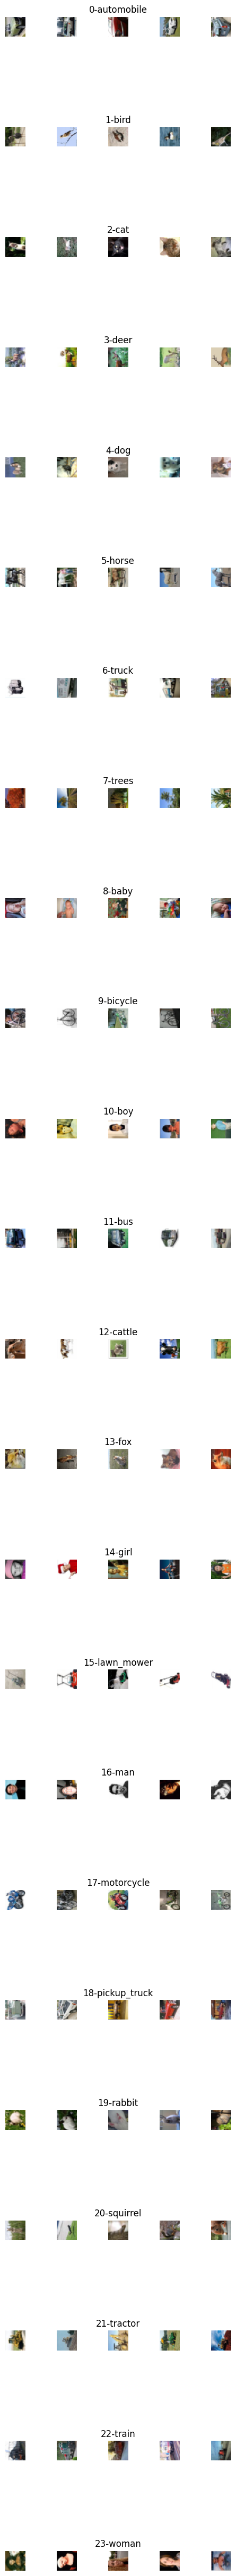

In [361]:
# GTS_SD4B_23.ipynb (johnloane-repo)
import random
num_of_samples = []
cols = 5
num_classes = 24
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
  for j in range(len(set(y_train))):
    x_selected = x_train[y_train == j]
    axs[j][i].imshow(load_image(x_selected[random.randint(0, len(x_selected)-1)]), cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      num_of_samples.append(len(x_selected))
      axs[j][i].set_title(str(dic_labels[j]) + '-' + str(dic_classnames[j]))

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 2500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


Text(0, 0.5, 'Number of images')

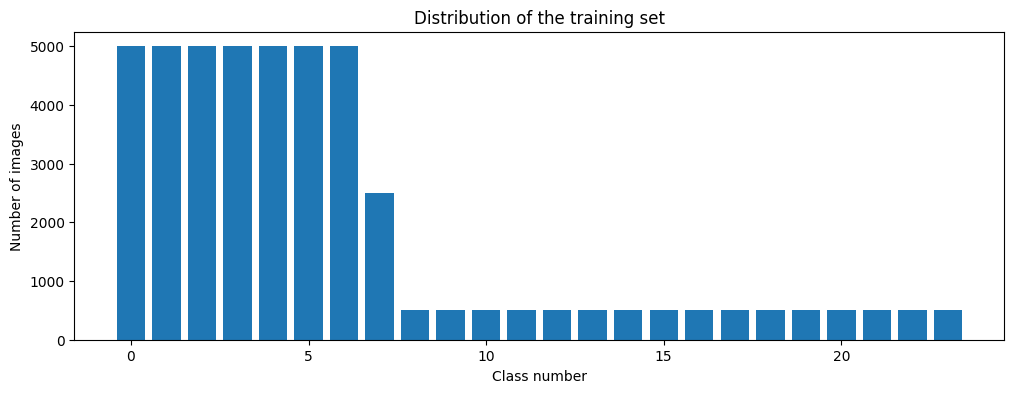

In [362]:
# GTS_SD4B_23.ipynb (johnloane-repo)
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training set")
plt.xlabel("Class number")
plt.ylabel("Number of images")

6


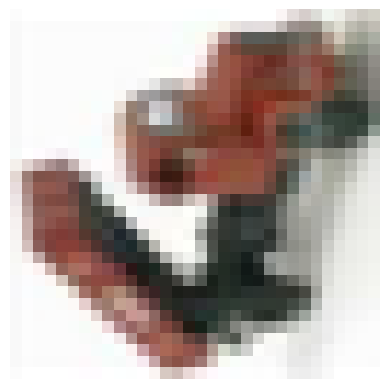

In [363]:
image = x_train[1000]
print(y_train[1000])
plt.imshow(load_image(image))
plt.axis('off')
plt.show()


(-0.5, 31.5, 31.5, -0.5)

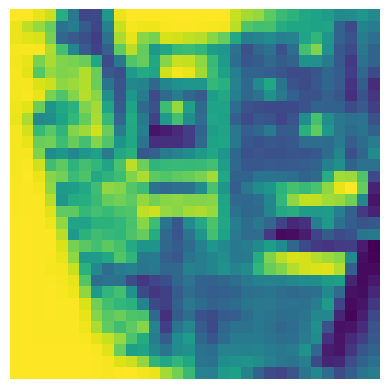

In [364]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img


img = grayscale(load_image(x_train[100]))
plt.imshow(img)
plt.axis("off")

(-0.5, 31.5, 31.5, -0.5)

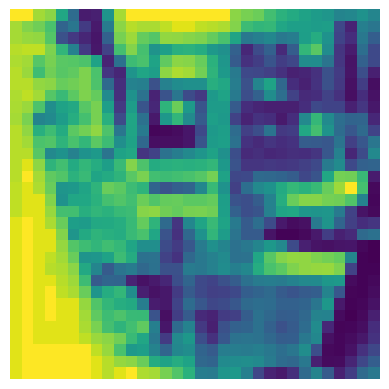

In [365]:

def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

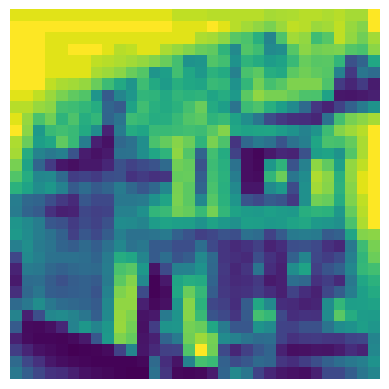

In [366]:
def rotate(img):
  img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  return img


img = rotate(img)
plt.imshow(img)
plt.axis('off')

In [367]:
def preprocess(img):
  img = load_image(img)
  img = grayscale(img)
  img = equalize(img)
  img = rotate(img)
  img = img/255
  return img

In [368]:
rd_index = random.randint(0, (len(x_train)-1))
label = y_train[rd_index]
img = x_train[rd_index]

6 truck


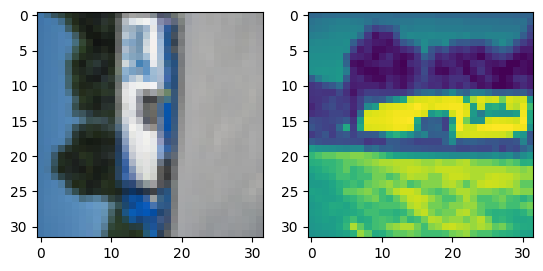

In [369]:
# Reshape whole image datasets
x_train = [preprocess(image) for image in x_train]
x_test = [preprocess(image) for image in x_test]

print(label, dic_classnames[label])
plt.subplot(1, 2, 1)
plt.imshow(load_image(img))
plt.subplot(1, 2, 2)
plt.imshow(x_train[rd_index])

In [370]:
def one_hot_encode_labels(y_train, y_test):
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    return y_train, y_test

In [371]:
# TODO :
# Load images to rgb
# get overview of images: number for each label, look of images

In [372]:
# IDEA:
# for superclass, change all fine_labels corresponding to superclass into one label (for avoiding label duplication, number >= 100)

# Preprocesing:
# Image is already 32x32x3, downscaling may lead to more information loss of the image
# Mapping to grey scale
# Contrast are not high, increase the contrasts